In [1]:
# # Detección de Phishing Bilingüe con Machine Learning
# ## Análisis de Características Específicas

# ### 1. Importación de librerías

import pandas as pd
import numpy as np
import re
import warnings
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
import time
from urllib.parse import urlparse
import ipaddress
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from pathlib import Path
import json, hashlib, csv

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix,
                           classification_report, matthews_corrcoef, cohen_kappa_score)

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

# Configuración
warnings.filterwarnings('ignore')
np.random.seed(42)

# Descargar recursos NLTK necesarios
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab', quiet=True)


True

In [2]:
# === Configuración ===
GARBAGE_CHARS = "*=+-_'.¡!"
GARBAGE_THRESHOLD = 10  # ajusta según tu dataset

# Compilamos un patrón que detecta “bloques” hechos solo de esos signos + espacios.
# Ojo: el umbral real se verifica contando SOLO los signos (no los espacios).
_garbage_block_re = re.compile(fr'[{re.escape(GARBAGE_CHARS)}\s]{{{GARBAGE_THRESHOLD},}}')

def remove_garbage_runs(text: str,
                        threshold: int = GARBAGE_THRESHOLD,
                        chars: str = GARBAGE_CHARS,
                        replacement: str = " ") -> str:
    if pd.isna(text):
        return ""

    def _repl(m: re.Match) -> str:
        g = m.group(0)
        # Cuenta solo los signos, ignora espacios
        punct_count = sum(ch in chars for ch in g)
        return replacement if punct_count >= threshold else g

    return _garbage_block_re.sub(_repl, text)

In [3]:
# ### 2. Funciones de detección y extracción de características

# Palabras clave de phishing por idioma
PHISHING_KEYWORDS = {
    'english': {
        'urgency': ['urgent', 'expire', 'suspend', 'immediate', 'limited time', 'act now', 
                   'hurry', 'deadline', 'critical', 'important notice'],
        'action': ['click here', 'verify', 'confirm', 'update', 'validate', 'secure',
                  'restore', 'unlock', 'activate', 'claim'],
        'money': ['account', 'payment', 'billing', 'credit', 'debit', 'bank', 'paypal',
                 'refund', 'prize', 'winner', 'lottery', 'tax'],
        'threat': ['suspended', 'blocked', 'restricted', 'locked', 'illegal', 'unauthorized',
                  'breach', 'compromised', 'violation', 'terminate']
    },
    'spanish': {
        'urgency': ['urgente', 'expira', 'suspender', 'inmediato', 'tiempo limitado', 
                   'actúa ahora', 'apresúrate', 'fecha límite', 'crítico', 'aviso importante'],
        'action': ['haga clic aquí', 'verificar', 'confirmar', 'actualizar', 'validar',
                  'asegurar', 'restaurar', 'desbloquear', 'activar', 'reclamar'],
        'money': ['cuenta', 'pago', 'facturación', 'crédito', 'débito', 'banco', 'paypal',
                 'reembolso', 'premio', 'ganador', 'lotería', 'impuesto'],
        'threat': ['suspendida', 'bloqueada', 'restringida', 'bloqueado', 'ilegal',
                  'no autorizado', 'violación', 'comprometido', 'infracción', 'terminar']
    }
}

# Dominios legítimos comunes (para detectar typosquatting)
LEGITIMATE_DOMAINS = ['paypal.com', 'amazon.com', 'google.com', 'microsoft.com', 
                     'apple.com', 'facebook.com', 'twitter.com', 'instagram.com',
                     'linkedin.com', 'netflix.com', 'ebay.com', 'dropbox.com',
                     'chase.com', 'wellsfargo.com', 'bankofamerica.com']

def detect_language(text):
    """Detectar idioma basado en palabras comunes"""
    spanish_words = set(['el', 'la', 'de', 'que', 'y', 'en', 'un', 'ser', 'se', 'no', 
                        'haber', 'por', 'con', 'su', 'para', 'como', 'estar', 'tener'])
    english_words = set(['the', 'be', 'to', 'of', 'and', 'a', 'in', 'that', 'have', 
                        'i', 'it', 'for', 'not', 'on', 'with', 'he', 'as', 'you'])
    
    if pd.isna(text):
        return 'unknown'
    
    words = text.lower().split()[:50]  # Primeras 50 palabras
    spanish_count = sum(1 for word in words if word in spanish_words)
    english_count = sum(1 for word in words if word in english_words)
    
    if spanish_count > english_count:
        return 'spanish'
    elif english_count > spanish_count:
        return 'english'
    else:
        return 'unknown'

def extract_url_features(text):
    """Extraer características específicas de URLs para detección de phishing"""
    features = {
        'url_count': 0,
        'shortened_url': 0,
        'has_ip': 0,
        'suspicious_domain': 0,
        'long_url': 0,
        'has_at_symbol': 0,
        'multiple_subdomains': 0,
        'https_count': 0,
        'http_count': 0
    }
    
    # Patrones de URL
    url_pattern = r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+'
    urls = re.findall(url_pattern, text.lower())
    
    features['url_count'] = len(urls)
    
    # URL shorteners comunes
    shorteners = ['bit.ly', 'tinyurl', 'goo.gl', 'ow.ly', 'short.link', 't.co']
    
    for url in urls:
        # URL acortada
        if any(short in url for short in shorteners):
            features['shortened_url'] += 1
        
        # Tiene IP en lugar de dominio
        try:
            parsed = urlparse(url)
            ipaddress.ip_address(parsed.hostname)
            features['has_ip'] += 1
        except:
            pass
        
        # URL larga (sospechosa)
        if len(url) > 75:
            features['long_url'] += 1
        
        # Tiene @ (redirección)
        if '@' in url:
            features['has_at_symbol'] += 1
        
        # Múltiples subdominios
        if url.count('.') > 3:
            features['multiple_subdomains'] += 1
        
        # HTTP vs HTTPS
        if url.startswith('https'):
            features['https_count'] += 1
        elif url.startswith('http:'):
            features['http_count'] += 1
    
    return features

def extract_phishing_features(text, language='english'):
    """Extraer características específicas de phishing"""
    features = {}
    text_lower = text.lower()
    
    # Contar palabras clave por categoría
    keywords = PHISHING_KEYWORDS.get(language, PHISHING_KEYWORDS['english'])
    
    for category, words in keywords.items():
        count = sum(1 for word in words if word in text_lower)
        features[f'{category}_words'] = count
    
    # Características adicionales
    features['exclamation_count'] = text.count('!')
    features['question_count'] = text.count('?')
    features['uppercase_words'] = len(re.findall(r'\b[A-Z]{2,}\b', text))
    features['special_chars'] = len(re.findall(r'[!@#$%^&*(),.?":{}|<>]', text))
    
    # Detectar emails
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    emails = re.findall(email_pattern, text)
    features['email_count'] = len(emails)
    
    # Verificar dominios sospechosos en emails
    suspicious_email = 0
    for email in emails:
        domain = email.split('@')[1].lower()
        # Buscar typosquatting
        for legit_domain in LEGITIMATE_DOMAINS:
            if domain != legit_domain and any([
                domain.replace('0', 'o') == legit_domain,
                domain.replace('1', 'l') == legit_domain,
                domain.replace('l', '1') == legit_domain,
                legit_domain.replace('.com', '') in domain
            ]):
                suspicious_email += 1
                break
    features['suspicious_email'] = suspicious_email
    
    return features

def phishing_preprocessing(text):
    """Preprocesamiento específico para phishing (preserva URLs y emails)"""
    if pd.isna(text):
        return ""
    
    # Convertir a string
    text = str(text)
    
    # Preservar URLs marcándolas temporalmente
    url_pattern = r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+'
    urls = re.findall(url_pattern, text)
    for i, url in enumerate(urls):
        text = text.replace(url, f" URL{i} ")
    
    # Preservar emails marcándolos temporalmente  
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    emails = re.findall(email_pattern, text)
    for i, email in enumerate(emails):
        text = text.replace(email, f" EMAIL{i} ")
    
    # Convertir a minúsculas
    text = text.lower()
    
    # Restaurar URLs y emails
    for i, url in enumerate(urls):
        text = text.replace(f"url{i}", url.lower())
    for i, email in enumerate(emails):
        text = text.replace(f"email{i}", email.lower())

    text = remove_garbage_runs(text, threshold=GARBAGE_THRESHOLD, chars=GARBAGE_CHARS, replacement=" ")
    
    # Eliminar espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def apply_stemming(text, language='english'):
    """Aplicar stemming preservando URLs y emails"""
    detected_lang = detect_language(text)
    
    # Preservar URLs y emails
    url_pattern = r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+'
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    
    urls = re.findall(url_pattern, text)
    emails = re.findall(email_pattern, text)
    
    # Reemplazar temporalmente
    for i, url in enumerate(urls):
        text = text.replace(url, f" URLTOKEN{i} ")
    for i, email in enumerate(emails):
        text = text.replace(email, f" EMAILTOKEN{i} ")
    
    # Aplicar stemming
    if detected_lang == 'spanish':
        stemmer = SnowballStemmer('spanish')
    else:
        stemmer = PorterStemmer()
    
    tokens = word_tokenize(text)
    stemmed_tokens = []
    
    for token in tokens:
        if token.startswith('URLTOKEN') or token.startswith('EMAILTOKEN'):
            stemmed_tokens.append(token)
        else:
            stemmed_tokens.append(stemmer.stem(token))
    
    text = ' '.join(stemmed_tokens)
    
    # Restaurar URLs y emails
    for i, url in enumerate(urls):
        text = text.replace(f"URLTOKEN{i}", url)
    for i, email in enumerate(emails):
        text = text.replace(f"EMAILTOKEN{i}", email)
    
    return text

def remove_stopwords_multilingual(text):
    """Eliminar stopwords preservando URLs y emails"""
    # Preservar URLs y emails como antes
    url_pattern = r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+'
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    
    urls = re.findall(url_pattern, text)
    emails = re.findall(email_pattern, text)
    
    for i, url in enumerate(urls):
        text = text.replace(url, f" URLTOKEN{i} ")
    for i, email in enumerate(emails):
        text = text.replace(email, f" EMAILTOKEN{i} ")
    
    # Eliminar stopwords
    stop_words_en = set(stopwords.words('english'))
    stop_words_es = set(stopwords.words('spanish'))
    stop_words_combined = stop_words_en.union(stop_words_es)
    
    tokens = word_tokenize(text)
    filtered_tokens = []
    
    for token in tokens:
        if token.startswith('URLTOKEN') or token.startswith('EMAILTOKEN') or token not in stop_words_combined:
            filtered_tokens.append(token)
    
    text = ' '.join(filtered_tokens)
    
    # Restaurar
    for i, url in enumerate(urls):
        text = text.replace(f"URLTOKEN{i}", url)
    for i, email in enumerate(emails):
        text = text.replace(f"EMAILTOKEN{i}", email)
    
    return text


In [4]:
# ### 3. Configuración de experimentos para phishing

# Configuraciones de preprocesamiento adaptadas para phishing
preprocessing_configs = [
    {
        'name': 'basic_phishing',
        'stemming': False,
        'lemmatization': False,
        'remove_stopwords': False,
        'extract_features': True,
        'vectorizer': 'tfidf',
        'max_features': 15000,
        'ngram_range': (1, 1)
    },
    {
        'name': 'phishing_bigram',
        'stemming': False,
        'lemmatization': False,
        'remove_stopwords': False,
        'extract_features': True,
        'vectorizer': 'tfidf',
        'max_features': 20000,
        'ngram_range': (1, 2)
    },
    {
        'name': 'phishing_trigram',
        'stemming': False,
        'lemmatization': False,
        'remove_stopwords': False,
        'extract_features': True,
        'vectorizer': 'tfidf',
        'max_features': 20000,
        'ngram_range': (1, 3)
    },
    {
        'name': 'phishing_char_ngram',
        'stemming': False,
        'lemmatization': False,
        'remove_stopwords': False,
        'extract_features': True,
        'vectorizer': 'tfidf',
        'max_features': 25000,
        'ngram_range': (2, 5),
        'analyzer': 'char_wb'  # Character n-grams para detectar typosquatting
    },
    {
        'name': 'phishing_stem_nostop',
        'stemming': True,
        'lemmatization': False,
        'remove_stopwords': True,
        'extract_features': True,
        'vectorizer': 'tfidf',
        'max_features': 15000,
        'ngram_range': (1, 2)
    },
    {
        'name': 'phishing_advanced',
        'stemming': True,
        'lemmatization': False,
        'remove_stopwords': True,
        'extract_features': True,
        'vectorizer': 'tfidf',
        'max_features': 25000,
        'ngram_range': (1, 3),
        'use_idf': True,
        'sublinear_tf': True
    },
    {
        'name': 'phishing_count_vector',
        'stemming': False,
        'lemmatization': False,
        'remove_stopwords': False,
        'extract_features': True,
        'vectorizer': 'count',
        'max_features': 20000,
        'ngram_range': (1, 2)
    },
    {
        'name': 'phishing_mixed_features',
        'stemming': False,
        'lemmatization': True,
        'remove_stopwords': True,
        'extract_features': True,
        'vectorizer': 'tfidf',
        'max_features': 30000,
        'ngram_range': (1, 3),
        'min_df': 2,
        'max_df': 0.95
    }
]

# Modelos con configuración optimizada para phishing
models = {
    'logistic_regression': LogisticRegression(
        max_iter=1000, 
        random_state=42, 
        n_jobs=1,
        class_weight='balanced'  # Importante para phishing
    ),
    'naive_bayes': MultinomialNB(alpha=0.1),
    'random_forest': RandomForestClassifier(
        n_estimators=200, 
        random_state=42, 
        n_jobs=1,
        class_weight='balanced',
        max_depth=20
    ),
    'xgboost': xgb.XGBClassifier(
        n_estimators=200, 
        random_state=42, 
        n_jobs=1,
        scale_pos_weight=2,  # Penalizar más los falsos negativos
        learning_rate=0.1
    ),
    'lightgbm': lgb.LGBMClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=1,
        class_weight='balanced',
        num_leaves=31
    ),
    'gradient_boosting': GradientBoostingClassifier(
        n_estimators=100,
        random_state=42,
        learning_rate=0.1,
        max_depth=5
    )
}


In [5]:
# ### 4. Funciones de preprocesamiento y evaluación

def preprocess_data(texts, config, language='english'):
    """Aplicar preprocesamiento según la configuración para phishing"""
    # Aplicar preprocesamiento específico de phishing
    processed_texts = texts.apply(phishing_preprocessing)
    
    # Aplicar técnicas adicionales según configuración
    if config['stemming']:
        processed_texts = processed_texts.apply(apply_stemming)
    
    if config['lemmatization']:
        # Usar lemmatización similar pero preservando URLs/emails
        processed_texts = processed_texts.apply(lambda x: apply_stemming(x))  # Simplificado
    
    if config['remove_stopwords']:
        processed_texts = processed_texts.apply(remove_stopwords_multilingual)
    
    return processed_texts

def extract_all_features(texts):
    """Extraer todas las características de phishing de los textos"""
    features_list = []
    
    for text in texts:
        # Detectar idioma
        lang = detect_language(text)
        if lang == 'unknown':
            lang = 'english'
        
        # Extraer características de URL
        url_features = extract_url_features(text)
        
        # Extraer características de phishing
        phishing_features = extract_phishing_features(text, lang)
        
        # Combinar todas las características
        all_features = {**url_features, **phishing_features}
        features_list.append(all_features)
    
    return pd.DataFrame(features_list)

def evaluate_model_phishing(y_true, y_pred, y_pred_proba=None):
    """Calcular métricas de evaluación con énfasis en detección de phishing"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred),
        'matthews_corrcoef': matthews_corrcoef(y_true, y_pred),
        'cohen_kappa': cohen_kappa_score(y_true, y_pred)
    }
    
    # AUC-ROC si tenemos probabilidades
    if y_pred_proba is not None:
        metrics['auc_roc'] = roc_auc_score(y_true, y_pred_proba)
    
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Tasas de error
    metrics['false_positive_rate'] = fp / (fp + tn) if (fp + tn) > 0 else 0
    metrics['false_negative_rate'] = fn / (fn + tp) if (fn + tp) > 0 else 0
    metrics['true_negatives'] = tn
    metrics['false_positives'] = fp
    metrics['false_negatives'] = fn
    metrics['true_positives'] = tp
    
    # Métrica de costo (considerando que un falso negativo es 10x más costoso)
    cost_fn = 10  # Costo de no detectar phishing
    cost_fp = 1   # Costo de falsa alarma
    metrics['weighted_cost'] = (fn * cost_fn + fp * cost_fp) / len(y_true)
    
    return metrics


In [6]:
# ### 5. Cargar y combinar datos

# Crear directorio para guardar modelos
os.makedirs('modelos_phishing', exist_ok=True)

# Cargar datasets
print("Cargando datasets...")
df_en = pd.read_csv('dataset_entrenamiento/phishing_data.csv')
df_es = pd.read_csv('dataset_entrenamiento/phishing_data_es.csv')

print(f"Dataset inglés: {df_en.shape}")
print(f"Dataset español: {df_es.shape}")

# Combinar subject y body
df_en['text'] = df_en['subject'].fillna('') + ' ' + df_en['body'].fillna('')
df_es['text'] = df_es['subject'].fillna('') + ' ' + df_es['body'].fillna('')

# Agregar columna de idioma
df_en['language'] = 'english'
df_es['language'] = 'spanish'

# Combinar ambos datasets
df_combined = pd.concat([df_en, df_es], ignore_index=True)
print(f"\nDataset combinado bilingüe: {df_combined.shape}")
print(f"Distribución de idiomas: {df_combined['language'].value_counts()}")
print(f"Distribución: {df_combined['label'].value_counts()}")
print(f"Ratio de correos maliciosos: {df_combined['label'].mean():.2%}")

# Análisis exploratorio de URLs y características
print("\n" + "="*50)
print("ANÁLISIS EXPLORATORIO DE CARACTERÍSTICAS")
print("="*50)

# Muestra de análisis
sample_df = df_combined.sample(min(5000, len(df_combined)), random_state=42)
sample_features = extract_all_features(sample_df['text'])

print("\nEstadísticas de características extraídas:")
print(sample_features.describe())

# Correlación con la etiqueta
sample_features['label'] = sample_df['label'].values
correlation_with_label = sample_features.corr()['label'].sort_values(ascending=False)
print("\nCorrelación de características:")
print(correlation_with_label.head(10))


Cargando datasets...
Dataset inglés: (75112, 4)
Dataset español: (75112, 4)

Dataset combinado bilingüe: (150224, 6)
Distribución de idiomas: language
english    75112
spanish    75112
Name: count, dtype: int64
Distribución: label
1    79216
0    71008
Name: count, dtype: int64
Ratio de correos maliciosos: 52.73%

ANÁLISIS EXPLORATORIO DE CARACTERÍSTICAS

Estadísticas de características extraídas:
         url_count  shortened_url       has_ip  suspicious_domain  long_url  \
count  5000.000000    5000.000000  5000.000000             5000.0    5000.0   
mean      1.163600       0.041000     0.000200                0.0       0.0   
std       4.339378       0.299561     0.014142                0.0       0.0   
min       0.000000       0.000000     0.000000                0.0       0.0   
25%       0.000000       0.000000     0.000000                0.0       0.0   
50%       0.000000       0.000000     0.000000                0.0       0.0   
75%       1.000000       0.000000     0.000000

In [7]:
# ### 6. Funciones de muestreo y entrenamiento

def sample_multilingual_data(df, train_size=40000, test_size=2000):
    """Muestrear datos manteniendo balance de clases e idiomas"""
    if len(df) < train_size + test_size:
        train_size = int(len(df) * 0.8)
        test_size = len(df) - train_size
    
    # Crear estratificación
    df['stratify_col'] = df['label'].astype(str) + '_' + df['language']
    
    X = df[['text', 'language']]
    y = df['label']
    stratify = df['stratify_col']
    
    # Split estratificado
    X_temp, X_test, y_temp, y_test, strat_temp, strat_test = train_test_split(
        X, y, stratify, 
        test_size=test_size,
        stratify=stratify,
        random_state=42
    )
    
    if len(X_temp) > train_size:
        fraction = train_size / len(X_temp)
        X_train, _, y_train, _ = train_test_split(
            X_temp, y_temp,
            train_size=fraction,
            stratify=strat_temp[:len(X_temp)],
            random_state=42
        )
    else:
        X_train, y_train = X_temp, y_temp
    
    return X_train, X_test, y_train, y_test
    

def balancear_datos(X, y, metodo='ninguno'):
    """Balancea los datos usando SMOTE o undersampling si se especifica"""
    if metodo == 'smote':
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X, y)
        return X_res, y_res
    elif metodo == 'undersampling':
        rus = RandomUnderSampler(random_state=42)
        X_res, y_res = rus.fit_resample(X, y)
        return X_res, y_res
    else:
        return X, y    
        

def train_and_evaluate_model_phishing(X_train, X_test, y_train, y_test, 
                                     X_train_features, X_test_features,
                                     model, model_name, preprocessing_name,
                                     balance_method='ninguno'):

    if X_train_features is not None:
        if hasattr(X_train, 'toarray'):
            X_train_text = X_train.toarray()
            X_test_text = X_test.toarray()
        else:
            X_train_text = X_train
            X_test_text = X_test

        if model_name == 'naive_bayes':
            X_train_combined = X_train
            X_test_combined = X_test
        else:
            X_train_combined = np.hstack([X_train_text, X_train_features])
            X_test_combined = np.hstack([X_test_text, X_test_features])
    else:
        X_train_combined = X_train
        X_test_combined = X_test

    # ✅ BALANCEO
    X_train_combined, y_train = balancear_datos(X_train_combined, y_train, metodo=balance_method)

    model.fit(X_train_combined, y_train)

    y_pred = model.predict(X_test_combined)
    try:
        y_pred_proba = model.predict_proba(X_test_combined)[:, 1]
    except:
        y_pred_proba = None

    metrics = evaluate_model_phishing(y_test, y_pred, y_pred_proba)
    metrics['model'] = model_name
    metrics['preprocessing'] = preprocessing_name
    metrics['balance_method'] = balance_method
    metrics['timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    return model, metrics

In [8]:
# ### 7. Experimento con enfoque gradual

def run_phishing_experiment(df_combined, train_size, experiment_name, 
                           configs_to_use=None, models_to_use=None,
                           balance_methods=['ninguno']):

    print(f"\n{'='*70}")
    print(f"EXPERIMENTO PHISHING: {experiment_name}")
    print(f"Tamaño de entrenamiento: {train_size:,} muestras")
    print(f"{'='*70}")

    start_time = time.time()

    X_train, X_test, y_train, y_test = sample_multilingual_data(
        df_combined, 
        train_size=train_size, 
        test_size=2000
    )

    print(f"\nDatos de entrenamiento: {len(X_train)}")
    print(f"  - Distribución de idiomas: {X_train['language'].value_counts().to_dict()}")
    print(f"  - Ratio de phishing: {y_train.mean():.2%}")

    X_train_features = extract_all_features(X_train['text'])
    X_test_features = extract_all_features(X_test['text'])

    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    X_train_features_scaled = scaler.fit_transform(X_train_features)
    X_test_features_scaled = scaler.transform(X_test_features)

    configs = configs_to_use if configs_to_use else preprocessing_configs
    models_dict = models_to_use if models_to_use else models

    results = []
    trained_models = []

    for balance_method in balance_methods:
        print(f"\n===== Balanceo: {balance_method.upper()} =====")

        for config in configs:
            print(f"\nPreprocesamiento: {config['name']}")

            X_train_text = preprocess_data(X_train['text'], config)
            X_test_text = preprocess_data(X_test['text'], config)

            vectorizer_params = {
                'max_features': config['max_features'],
                'ngram_range': config['ngram_range'],
                'min_df': config.get('min_df', 2),
                'max_df': config.get('max_df', 0.95),
                'token_pattern': r'(?u)\b\w+\b|https?://\S+|[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'
            }

            if 'analyzer' in config:
                vectorizer_params['analyzer'] = config['analyzer']
            if 'use_idf' in config:
                vectorizer_params['use_idf'] = config['use_idf']
            if 'sublinear_tf' in config:
                vectorizer_params['sublinear_tf'] = config['sublinear_tf']

            vectorizer = TfidfVectorizer(**vectorizer_params) if config['vectorizer'] == 'tfidf' else CountVectorizer(**vectorizer_params)

            print(f"  Vectorizando textos...")
            X_train_vec = vectorizer.fit_transform(X_train_text)
            X_test_vec = vectorizer.transform(X_test_text)

            use_extracted_features = config.get('extract_features', True)

            for model_name, model_obj in models_dict.items():
                print(f"  - Entrenando {model_name}...")

                model = model_obj.__class__(**model_obj.get_params())

                if use_extracted_features:
                    trained_model, metrics = train_and_evaluate_model_phishing(
                        X_train_vec, X_test_vec, y_train, y_test,
                        X_train_features_scaled, X_test_features_scaled,
                        model, model_name, config['name'],
                        balance_method=balance_method
                    )
                else:
                    trained_model, metrics = train_and_evaluate_model_phishing(
                        X_train_vec, X_test_vec, y_train, y_test,
                        None, None,
                        model, model_name, config['name'],
                        balance_method=balance_method
                    )

                metrics['train_size'] = train_size
                metrics['experiment'] = experiment_name
                metrics['used_extracted_features'] = use_extracted_features

                results.append(metrics)
                trained_models.append({
                    'model': trained_model,
                    'vectorizer': vectorizer,
                    'scaler': scaler if use_extracted_features else None,
                    'config': config,
                    'metrics': metrics,
                    'X_test': X_test,
                    'y_test': y_test
                })

                print(f"    Recall={metrics['recall']:.4f}, F1={metrics['f1_score']:.4f}, FPR={metrics['false_positive_rate']:.4f}, Cost={metrics['weighted_cost']:.4f}")

    elapsed_time = time.time() - start_time
    print(f"\nTiempo total del experimento: {elapsed_time/60:.1f} minutos")

    return pd.DataFrame(results), trained_models

In [9]:
# ### 8. Ejecución de experimentos graduales

def seleccionar_mejores_combinaciones(resultados_df, top_n=5, metric='recall'):
    """Agrupa por modelo + preprocesamiento + balanceo y selecciona top N por métrica"""
    resultados_df['combo_id'] = resultados_df['model'] + ' + ' + resultados_df['preprocessing'] + ' + ' + resultados_df['balance_method']
    mejores = resultados_df.sort_values(by=metric, ascending=False).drop_duplicates('combo_id').head(top_n)
    return mejores

# Experimento 1: Exploración rápida
results_all, models_all = run_phishing_experiment(
    df_combined,
    train_size=10000,
    experiment_name="Exploración Multi-Balanceo",
    balance_methods=['ninguno', 'smote', 'undersampling']
)
# Guardar resultados
results_all.to_csv('modelos_phishing/resultados_multi_balanceo.csv', index=False)

# Identificar las mejores combinaciones (priorizando recall)
mejores_combos = seleccionar_mejores_combinaciones(results_all, top_n=5)
mejores_combos[['model', 'preprocessing', 'balance_method', 'recall', 'f1_score', 'weighted_cost']]

print("\n" + "="*50)
print("TOP 5 MEJORES COMBINACIONES (por Recall)")
print("="*50)
print(mejores_combos)

# Experimento 2: Optimización
best_configs = []
best_models = {}
best_balances = set()

for _, row in mejores_combos.iterrows():
    config = next(c for c in preprocessing_configs if c['name'] == row['preprocessing'])
    if config not in best_configs:
        best_configs.append(config)
    
    if row['model'] not in best_models:
        best_models[row['model']] = models[row['model']]

    best_balances.add(row['balance_method'])

print("Configuraciones seleccionadas:", [c['name'] for c in best_configs])
print("Modelos seleccionados:", list(best_models.keys()))
print("Métodos de balanceo seleccionados:", list(best_balances))

results_opt, models_opt = run_phishing_experiment(
    df_combined,
    train_size=30000,
    experiment_name="Optimización Balanceada",
    configs_to_use=best_configs,
    models_to_use=best_models,
    balance_methods=list(best_balances)
)
results_opt.to_csv('modelos_phishing/resultados_optimizacion_balanceada.csv', index=False)

# Experimento 3: Modelo final
mejor_final = seleccionar_mejores_combinaciones(results_opt, top_n=1).iloc[0]
final_config = next(c for c in preprocessing_configs if c['name'] == mejor_final['preprocessing'])
final_model = {mejor_final['model']: models[mejor_final['model']]}
final_balance = [mejor_final['balance_method']]

print("🏁 Mejor combinación final:")
print(mejor_final[['model', 'preprocessing', 'balance_method', 'recall', 'f1_score']])

results_final, models_final = run_phishing_experiment(
    df_combined,
    train_size=90000,
    experiment_name="Modelo Final Balanceado",
    configs_to_use=[final_config],
    models_to_use=final_model,
    balance_methods=final_balance
)
results_final.to_csv('modelos_phishing/resultados_modelo_final_balanceado.csv', index=False)



EXPERIMENTO PHISHING: Exploración Multi-Balanceo
Tamaño de entrenamiento: 10,000 muestras

Datos de entrenamiento: 10000
  - Distribución de idiomas: {'english': 5000, 'spanish': 5000}
  - Ratio de phishing: 52.74%

===== Balanceo: NINGUNO =====

Preprocesamiento: basic_phishing
  Vectorizando textos...
  - Entrenando logistic_regression...
    Recall=0.9791, F1=0.9736, FPR=0.0359, Cost=0.1270
  - Entrenando naive_bayes...
    Recall=0.9545, F1=0.9678, FPR=0.0201, Cost=0.2495
  - Entrenando random_forest...
    Recall=0.9602, F1=0.9538, FPR=0.0592, Cost=0.2380
  - Entrenando xgboost...
    Recall=0.9896, F1=0.9666, FPR=0.0645, Cost=0.0855
  - Entrenando lightgbm...
[LightGBM] [Info] Number of positive: 5274, number of negative: 4726
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.383556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2

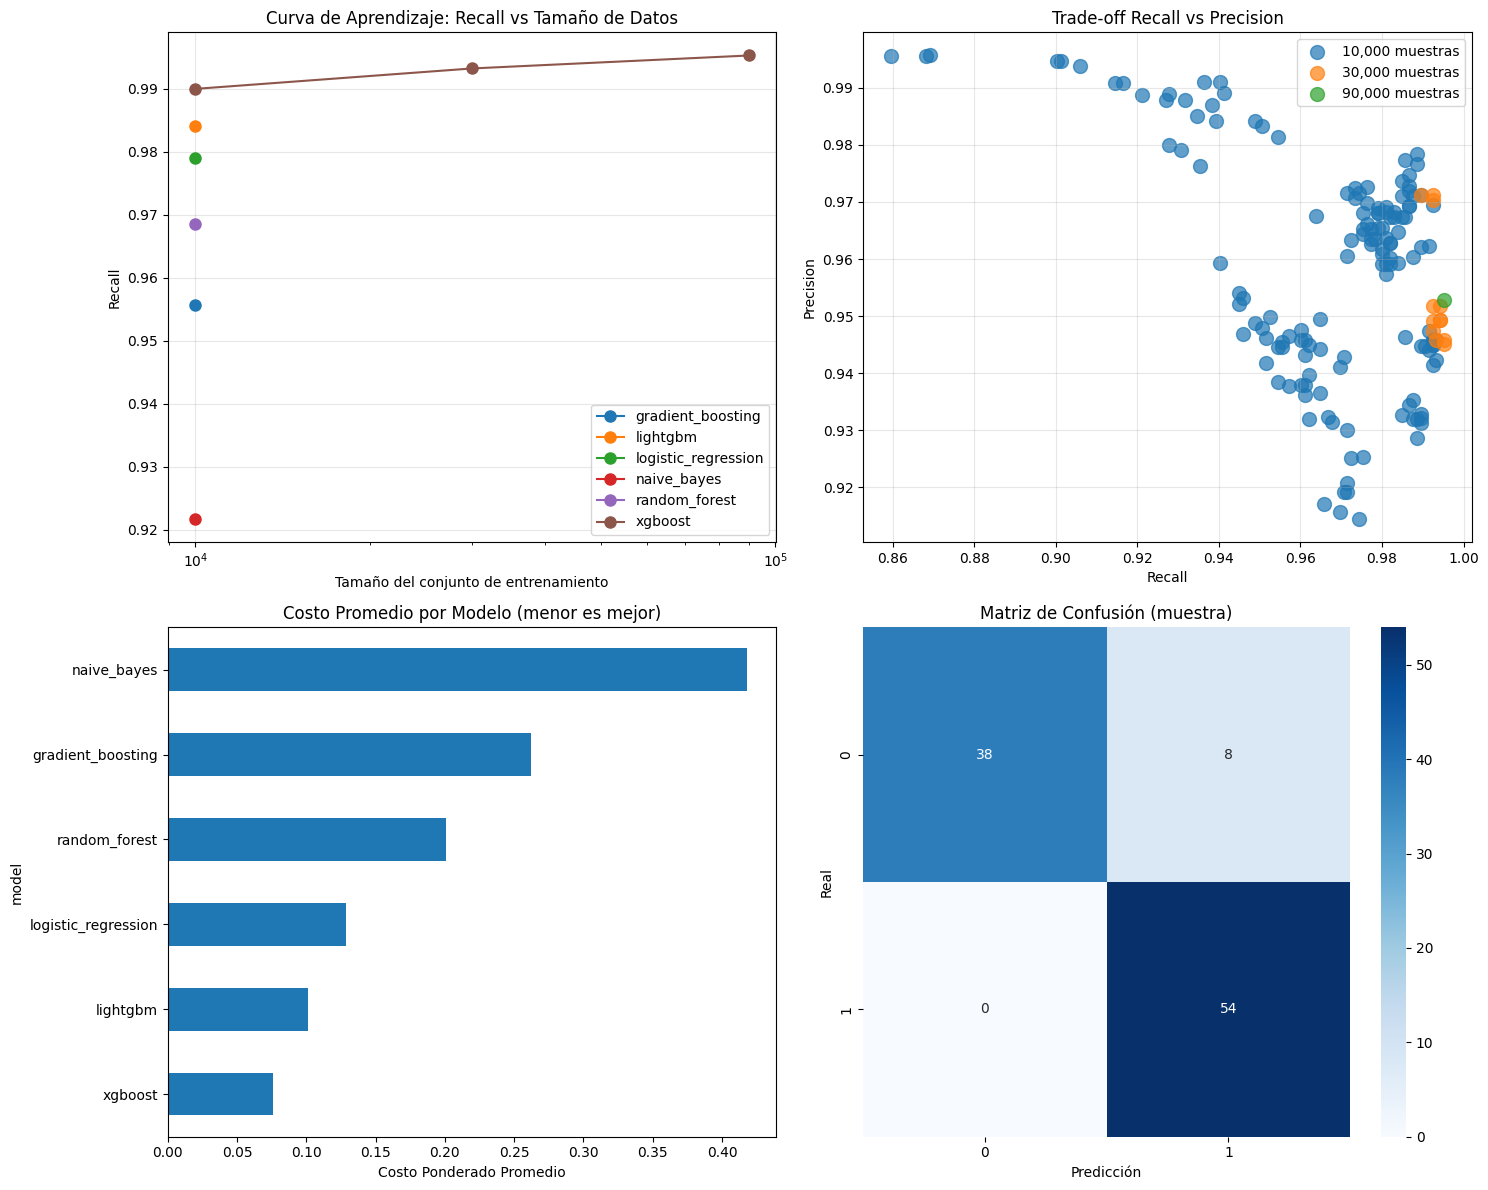

In [10]:
# ### 9. Análisis y visualizaciones

# Combinar todos los resultados
all_results = pd.concat([results_all, results_opt, results_final], ignore_index=True)
all_results.to_csv('modelos_phishing/resultados_todos_experimentos.csv', index=False)

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Curva de aprendizaje para Recall
learning_curve = all_results.groupby(['train_size', 'model'])[['recall', 'f1_score']].mean().reset_index()
for model in learning_curve['model'].unique():
    model_data = learning_curve[learning_curve['model'] == model]
    axes[0,0].plot(model_data['train_size'], model_data['recall'], 'o-', label=model, markersize=8)

axes[0,0].set_xlabel('Tamaño del conjunto de entrenamiento')
axes[0,0].set_ylabel('Recall')
axes[0,0].set_title('Curva de Aprendizaje: Recall vs Tamaño de Datos')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_xscale('log')

# 2. Trade-off Recall vs Precision
for size in all_results['train_size'].unique():
    size_data = all_results[all_results['train_size'] == size]
    axes[0,1].scatter(size_data['recall'], size_data['precision'], 
                      label=f'{size:,} muestras', s=100, alpha=0.7)
axes[0,1].set_xlabel('Recall')
axes[0,1].set_ylabel('Precision')
axes[0,1].set_title('Trade-off Recall vs Precision')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Costo ponderado por modelo
cost_by_model = all_results.groupby('model')['weighted_cost'].mean().sort_values()
cost_by_model.plot(kind='barh', ax=axes[1,0])
axes[1,0].set_xlabel('Costo Ponderado Promedio')
axes[1,0].set_title('Costo Promedio por Modelo (menor es mejor)')

# 4. Matriz de confusión del mejor modelo
best_model_info = sorted(models_all + models_opt + models_final, 
                        key=lambda x: x['metrics']['recall'], reverse=True)[0]

# Reconstruir las características correctamente
sample_size = min(100, len(best_model_info['y_test']))
X_test_sample = best_model_info['X_test']['text'][:sample_size]
y_test_sample = best_model_info['y_test'][:sample_size]

# Preprocesar texto
X_test_processed = preprocess_data(X_test_sample, best_model_info['config'])
X_test_vec = best_model_info['vectorizer'].transform(X_test_processed)

# Si el modelo usó características extraídas, agregarlas
if best_model_info['config'].get('extract_features', True) and best_model_info['scaler'] is not None:
    # Extraer características
    X_test_features = extract_all_features(X_test_sample)
    X_test_features_scaled = best_model_info['scaler'].transform(X_test_features)
    
    # Combinar características según el tipo de modelo
    if best_model_info['metrics']['model'] == 'naive_bayes':
        # Para Naive Bayes, usar solo características de texto
        X_test_combined = X_test_vec
    else:
        # Para otros modelos, combinar todas las características
        if hasattr(X_test_vec, 'toarray'):
            X_test_combined = np.hstack([X_test_vec.toarray(), X_test_features_scaled])
        else:
            X_test_combined = np.hstack([X_test_vec, X_test_features_scaled])
else:
    X_test_combined = X_test_vec

# Predecir
y_pred_sample = best_model_info['model'].predict(X_test_combined)

# Crear matriz de confusión
cm = confusion_matrix(y_test_sample, y_pred_sample)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,1])
axes[1,1].set_title('Matriz de Confusión (muestra)')
axes[1,1].set_xlabel('Predicción')
axes[1,1].set_ylabel('Real')

plt.tight_layout()
plt.savefig('modelos_phishing/analisis_phishing.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# ### 10. Guardar los mejores modelos -- cuidado, ejecutar la de abajo

# Ordenar por recall
all_models = models_all + models_opt + models_final
all_models_sorted = sorted(all_models, key=lambda x: x['metrics']['recall'], reverse=True)

print("\n" + "="*50)
print("GUARDANDO LOS 10 MEJORES MODELOS ANTI-PHISHING")
print("="*50)

for i, model_info in enumerate(all_models_sorted[:10]):
    filename = f"modelo_phishing_{i+1}_{model_info['metrics']['model']}_{model_info['config']['name']}_{model_info['metrics']['train_size']}"
    
    # Guardar modelo
    joblib.dump(model_info['model'], f"modelos_phishing/{filename}_model.pkl")
    
    # Guardar vectorizer
    joblib.dump(model_info['vectorizer'], f"modelos_phishing/{filename}_vectorizer.pkl")
    
    # Guardar scaler si existe
    if model_info['scaler'] is not None:
        joblib.dump(model_info['scaler'], f"modelos_phishing/{filename}_scaler.pkl")
    
    # Guardar configuración
    joblib.dump({
        'config': model_info['config'],
        'metrics': model_info['metrics']
    }, f"modelos_phishing/{filename}_config.pkl")
    
    print(f"  {i+1}. {filename}")
    print(f"     Recall: {model_info['metrics']['recall']:.4f}, "
          f"F1: {model_info['metrics']['f1_score']:.4f}, "
          f"Cost: {model_info['metrics']['weighted_cost']:.4f}")


In [12]:
# === Guardar TODOS los modelos, uno por carpeta ===

def slugify(s: str, maxlen: int = 120) -> str:
    """Convierte s en un nombre de carpeta seguro y corto."""
    s = str(s).strip()
    s = re.sub(r'\s+', '-', s)
    s = re.sub(r'[^A-Za-z0-9._-]+', '-', s)
    s = re.sub(r'-+', '-', s).strip('-')
    return s[:maxlen]

base_dir = Path("modelos_phishing")
base_dir.mkdir(parents=True, exist_ok=True)

# Ordenar por recall (igual que antes)
all_models = models_all + models_opt + models_final
all_models_sorted = sorted(all_models, key=lambda x: x['metrics']['recall'], reverse=True)

print("\n" + "="*50)
print(f"GUARDANDO {len(all_models_sorted)} MODELOS ANTI-PHISHING (uno por carpeta)")
print("="*50)

summary_rows = []

for i, model_info in enumerate(all_models_sorted, start=1):
    metrics = model_info['metrics']
    config  = model_info['config']

    # Nombre de carpeta: rank_modelo_config_trainSize (sanitizado)
    folder_stem = f"{i:03d}_{metrics.get('model','modelo')}_{config.get('name','cfg')}_{metrics.get('train_size','')}"
    folder_stem = slugify(folder_stem)
    out_dir = base_dir / folder_stem

    # Evitar colisiones si ya existe
    n = 1
    while out_dir.exists():
        out_dir = base_dir / f"{folder_stem}-{n}"
        n += 1
    out_dir.mkdir(parents=True, exist_ok=False)

    # Guardar artefactos
    joblib.dump(model_info['model'], out_dir / "model.pkl")
    if model_info.get('vectorizer') is not None:
        joblib.dump(model_info['vectorizer'], out_dir / "vectorizer.pkl")
    if model_info.get('scaler') is not None:
        joblib.dump(model_info['scaler'], out_dir / "scaler.pkl")

    # Metadata (útil para inspección y carga posterior)
    meta = {
        "rank": i,
        "created_at": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
        "id": hashlib.md5((folder_stem + json.dumps(metrics, sort_keys=True, default=str)).encode()).hexdigest()[:10],
        "config": config,
        "metrics": metrics,
        "artifacts": [p.name for p in out_dir.iterdir()]
    }
    #with open(out_dir / "metadata.json", "w", encoding="utf-8") as fh:
    #    json.dump(meta, fh, ensure_ascii=False, indent=2)

    summary_rows.append({
        "rank": i,
        "folder": out_dir.name,
        "model": metrics.get('model'),
        "config_name": config.get('name'),
        "recall": metrics.get('recall'),
        "f1": metrics.get('f1_score'),
        "cost": metrics.get('weighted_cost'),
        "train_size": metrics.get('train_size'),
    })

    print(f"  {i}. {out_dir.name}")
    print(f"     Recall: {metrics['recall']:.4f}, F1: {metrics['f1_score']:.4f}, Cost: {metrics['weighted_cost']:.4f}")

# (Opcional) Resumen en CSV para explorar rápido
if summary_rows:
    with open(base_dir / "summary.csv", "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=summary_rows[0].keys())
        writer.writeheader()
        writer.writerows(summary_rows)

# (Opcional) Listado de los 10 mejores (por recall) para referencia rápida
top10 = [row["folder"] for row in summary_rows[:10]]
with open(base_dir / "BEST_10.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(top10))



GUARDANDO 157 MODELOS ANTI-PHISHING (uno por carpeta)
  1. 001_xgboost_phishing_count_vector_30000-1
     Recall: 0.9953, F1: 0.9699, Cost: 0.0550
  2. 002_xgboost_phishing_count_vector_30000
     Recall: 0.9953, F1: 0.9695, Cost: 0.0555
  3. 003_xgboost_phishing_count_vector_90000
     Recall: 0.9953, F1: 0.9735, Cost: 0.0510
  4. 004_xgboost_phishing_count_vector_30000
     Recall: 0.9943, F1: 0.9713, Cost: 0.0580
  5. 005_xgboost_basic_phishing_30000
     Recall: 0.9943, F1: 0.9726, Cost: 0.0565
  6. 006_xgboost_basic_phishing_30000
     Recall: 0.9943, F1: 0.9713, Cost: 0.0580
  7. 007_xgboost_basic_phishing_10000
     Recall: 0.9934, F1: 0.9690, Cost: 0.0650
  8. 008_xgboost_phishing_count_vector_10000
     Recall: 0.9934, F1: 0.9672, Cost: 0.0670
  9. 009_xgboost_phishing_trigram_30000
     Recall: 0.9934, F1: 0.9690, Cost: 0.0650
  10. 010_xgboost_phishing_bigram_10000
     Recall: 0.9924, F1: 0.9663, Cost: 0.0725
  11. 011_xgboost_phishing_trigram_10000
     Recall: 0.9924, F1

In [13]:
# ### 11. Análisis detallado del mejor modelo

best_model_info = all_models_sorted[0]
print("\n" + "="*50)
print("ANÁLISIS DETALLADO DEL MEJOR MODELO ANTI-PHISHING")
print("="*50)
print(f"Modelo: {best_model_info['metrics']['model']}")
print(f"Preprocesamiento: {best_model_info['config']['name']}")
print(f"Tamaño de entrenamiento: {best_model_info['metrics']['train_size']:,}")
print(f"Recall: {best_model_info['metrics']['recall']:.4f}")
print(f"Precision: {best_model_info['metrics']['precision']:.4f}")
print(f"F1-Score: {best_model_info['metrics']['f1_score']:.4f}")
print(f"Costo ponderado: {best_model_info['metrics']['weighted_cost']:.4f}")

# Análisis de características importantes
if hasattr(best_model_info['model'], 'feature_importances_'):
    print("\nCaracterísticas más importantes (Random Forest/XGBoost):")
    # Aquí va el análisis de importancia de características
elif hasattr(best_model_info['model'], 'coef_'):
    print("\nIndicadores más fuertes de phishing:")
    # Convertir coeficientes si es necesario
    if hasattr(best_model_info['model'].coef_, 'toarray'):
        coef = best_model_info['model'].coef_.toarray()[0]
    else:
        coef = best_model_info['model'].coef_[0]
    
    # Obtener nombres de características
    feature_names = list(best_model_info['vectorizer'].get_feature_names_out())
    
    # Agregar nombres de características extraídas
    extracted_feature_names = ['url_count', 'shortened_url', 'has_ip', 'suspicious_domain',
                              'long_url', 'has_at_symbol', 'multiple_subdomains', 'https_count',
                              'http_count', 'urgency_words', 'action_words', 'money_words',
                              'threat_words', 'exclamation_count', 'question_count',
                              'uppercase_words', 'special_chars', 'email_count', 'suspicious_email']
    
    if best_model_info['config'].get('extract_features', True):
        feature_names.extend(extracted_feature_names)
    
    # Top indicadores de phishing
    indices = np.argsort(coef)[::-1][:20]
    print("\nTop 20 indicadores de PHISHING:")
    for i, idx in enumerate(indices):
        if idx < len(feature_names):
            print(f"  {i+1}. {feature_names[idx]}: {coef[idx]:.4f}")



ANÁLISIS DETALLADO DEL MEJOR MODELO ANTI-PHISHING
Modelo: xgboost
Preprocesamiento: phishing_count_vector
Tamaño de entrenamiento: 30,000
Recall: 0.9953
Precision: 0.9459
F1-Score: 0.9699
Costo ponderado: 0.0550

Características más importantes (Random Forest/XGBoost):


In [14]:
# ### 12. Prueba final con ejemplos reales

print("\n" + "="*50)
print("PRUEBA FINAL CON EJEMPLOS DE PHISHING")
print("="*50)

test_emails = [
    # Phishing en inglés
    "Dear Customer, Your account security requires immediate attention! Click here http://bit.ly/verify-account to prevent suspension.",
    "URGENT: $1000 has been debited from your account. If this wasn't you, click here immediately: http://192.168.1.1/secure",
    "Congratulations! You've won a $500 Amazon gift card. Claim now: http://amaz0n-gifts.com/claim",
    
    # Legítimo en inglés
    "Your order #12345 has been shipped via FedEx. Track your package at fedex.com/tracking",
    "Reminder: Your dentist appointment is tomorrow at 3 PM. Reply CONFIRM to confirm.",
    
    # Phishing en español
    "¡ALERTA! Actividad sospechosa en su cuenta. Verifique ahora: http://banc0-seguro.com/verificar",
    "Su tarjeta será bloqueada en 24 horas. Actualice sus datos aquí: http://bit.ly/banco-update",
    
    # Legítimo en español
    "Gracias por su compra. Su factura está disponible en su cuenta de cliente.",
    "Recordatorio: Su cita médica es mañana a las 15:00 en nuestra clínica."
]

# Procesar ejemplos
best_model = best_model_info['model']
best_vectorizer = best_model_info['vectorizer']
best_scaler = best_model_info['scaler']
best_config = best_model_info['config']

for i, email in enumerate(test_emails):
    # Preprocesar
    processed = preprocess_data(pd.Series([email]), best_config).iloc[0]
    text_vec = best_vectorizer.transform([processed])
    
    # Extraer características
    features_df = extract_all_features([email])
    features_scaled = best_scaler.transform(features_df) if best_scaler else features_df
    
    # Combinar
    if hasattr(text_vec, 'toarray'):
        combined = np.hstack([text_vec.toarray(), features_scaled])
    else:
        combined = np.hstack([text_vec, features_scaled])
    
    # Predecir
    pred = best_model.predict(combined)[0]
    prob = best_model.predict_proba(combined)[0][1]
    
    resultado = "PHISHING" if pred == 1 else "LEGÍTIMO"
    riesgo = "ALTO" if prob > 0.8 else "MEDIO" if prob > 0.5 else "BAJO"
    
    print(f"\n{i+1}. {resultado} (Probabilidad: {prob:.2%}, Riesgo: {riesgo})")
    print(f"   {email[:80]}...")



PRUEBA FINAL CON EJEMPLOS DE PHISHING

1. PHISHING (Probabilidad: 98.52%, Riesgo: ALTO)
   Dear Customer, Your account security requires immediate attention! Click here ht...

2. PHISHING (Probabilidad: 96.56%, Riesgo: ALTO)
   URGENT: $1000 has been debited from your account. If this wasn't you, click here...

3. PHISHING (Probabilidad: 98.68%, Riesgo: ALTO)
   Congratulations! You've won a $500 Amazon gift card. Claim now: http://amaz0n-gi...

4. PHISHING (Probabilidad: 98.44%, Riesgo: ALTO)
   Your order #12345 has been shipped via FedEx. Track your package at fedex.com/tr...

5. PHISHING (Probabilidad: 75.18%, Riesgo: MEDIO)
   Reminder: Your dentist appointment is tomorrow at 3 PM. Reply CONFIRM to confirm...

6. PHISHING (Probabilidad: 98.99%, Riesgo: ALTO)
   ¡ALERTA! Actividad sospechosa en su cuenta. Verifique ahora: http://banc0-seguro...

7. PHISHING (Probabilidad: 88.33%, Riesgo: ALTO)
   Su tarjeta será bloqueada en 24 horas. Actualice sus datos aquí: http://bit.ly/b...



In [15]:
# ### 13. Resumen final

print("\n" + "="*70)
print("RESUMEN FINAL - DETECCIÓN DE PHISHING")
print("="*70)

# Comparación de métricas clave
summary = all_results.groupby('train_size').agg({
    'recall': ['mean', 'max'],
    'precision': ['mean', 'max'],
    'f1_score': ['mean', 'max'],
    'weighted_cost': ['mean', 'min']
}).round(4)

print("\nImpacto del tamaño de datos:")
print(summary)

# Obtener los tamaños de entrenamiento disponibles
train_sizes = sorted(all_results['train_size'].unique())
print(f"\nTamaños de entrenamiento disponibles: {train_sizes}")

# Mejora en recall (comparar el menor con el mayor tamaño disponible)
if len(train_sizes) >= 2:
    smallest_size = train_sizes[0]
    largest_size = train_sizes[-1]
    
    mejora_recall = (summary.loc[largest_size, ('recall', 'max')] / 
                     summary.loc[smallest_size, ('recall', 'max')] - 1) * 100
    print(f"\nMejora en Recall: {mejora_recall:.1f}% ({smallest_size:,} → {largest_size:,} muestras)")
else:
    print("\nNo hay suficientes tamaños de entrenamiento para calcular mejora")

print(f"\nTotal de experimentos: {len(all_results)}")

# Encontrar el mejor modelo global
best_idx = all_results['recall'].idxmax()
best_result_global = all_results.loc[best_idx]

print(f"\nMEJOR MODELO ANTI-PHISHING:")
print(f"  - Algoritmo: {best_result_global['model']}")
print(f"  - Preprocesamiento: {best_result_global['preprocessing']}")
print(f"  - Tamaño de entrenamiento: {int(best_result_global['train_size']):,}")
print(f"  - Recall: {best_result_global['recall']:.4f} (crítico para phishing)")
print(f"  - Precision: {best_result_global['precision']:.4f}")
print(f"  - F1-Score: {best_result_global['f1_score']:.4f}")
print(f"  - Falsos Negativos: {best_result_global['false_negative_rate']:.4f}")
print(f"  - Costo ponderado: {best_result_global['weighted_cost']:.4f}")

# Estadísticas adicionales por modelo
print("\nRendimiento promedio por modelo (todos los tamaños):")
model_stats = all_results.groupby('model')[['recall', 'precision', 'f1_score', 'weighted_cost']].mean().round(4)
print(model_stats.sort_values('recall', ascending=False))

print("\n¡Proceso completado exitosamente!")
print("\nArchivos generados en 'modelos_phishing/':")
print("  - resultados_todos_experimentos.csv")
print("  - analisis_phishing.png")
print("  - 10 mejores modelos con alta detección de phishing")
print("  - ejemplo_uso_phishing.py")

print("\n⚠️  IMPORTANTE: El modelo prioriza la detección (alto recall) para minimizar")
print("   el riesgo de que emails de phishing lleguen a los usuarios.")


RESUMEN FINAL - DETECCIÓN DE PHISHING

Impacto del tamaño de datos:
            recall         precision         f1_score         weighted_cost  \
              mean     max      mean     max     mean     max          mean   
train_size                                                                    
10000       0.9665  0.9934    0.9583  0.9957   0.9620  0.9835        0.1992   
30000       0.9932  0.9953    0.9540  0.9712   0.9732  0.9817        0.0611   
90000       0.9953  0.9953    0.9528  0.9528   0.9735  0.9735        0.0510   

                    
               min  
train_size          
10000       0.0565  
30000       0.0550  
90000       0.0510  

Tamaños de entrenamiento disponibles: [10000, 30000, 90000]

Mejora en Recall: 0.2% (10,000 → 90,000 muestras)

Total de experimentos: 157

MEJOR MODELO ANTI-PHISHING:
  - Algoritmo: xgboost
  - Preprocesamiento: phishing_count_vector
  - Tamaño de entrenamiento: 30,000
  - Recall: 0.9953 (crítico para phishing)
  - Precision: 